## Trabalho 2 - Perceptron e MLP

## Equipe:

### João Lucas Lima Monteiro - 473521

### Caio Martim Barros - 472713

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification, make_moons
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

## Implementação de um Classificador Perceptron e Multilayer Perceptron

In [2]:
class Perceptron(object):
    """Classificador Perceptron.

    Parâmetros
    ------------
    eta : float
      Taxa de aprendizado (entre 0.0 e 1.0).
    n_iter : int
      Número de passagens pelo conjunto de dados de treinamento.
    random_state : int
      Semente do gerador de números aleatórios para inicialização
      dos pesos aleatórios.

    Atributos
    -----------
    w_ : array 1D
      Pesos após o ajuste.
    errors_ : lista
      Número de classificações incorretas (atualizações) em cada época.

    """

    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Ajusta os dados de treinamento.

        Parâmetros
        ----------
        X : {array-like}, shape = [n_exemplos, n_atributos]
          Vetores de treinamento, onde n_exemplos é o número de exemplos e
          n_atributos é o número de atributos.
        y : array-like, shape = [n_exemplos]
          Valores alvo.

        Retorna
        -------
        self : objeto

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            erros = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                erros += int(update != 0.0)
            self.errors_.append(erros)
        return self

    def net_input(self, X):
        """Calcula a entrada líquida"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Retorna a etiqueta de classe após a etapa unitária"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

## Testando o classificador Perceptron

In [3]:
"""Dados de Treinamento """
X = np.array([[1, 1], [2, 2], [3, 3]])
y = np.array([1, 1, -1])

"""Criando objeto Perceptron"""
ppn = Perceptron(eta=0.1, n_iter=1000)

"""Treinando o modelo"""
ppn.fit(X, y)

"""Testando modelo treinado """
X_newdata = np.array([[4, 4], [2, 2], [3, 3]])
print("Resultado da Predição", ppn.predict(X_newdata))

Resultado da Predição [-1  1 -1]


## Questao 1 - Implementar o modelo Multilayer Perceptron (MLP) e testar este classificador

In [4]:
class MLPClassifier:
    """Classificador Multi-Layer Perceptron (MLP).

    Parâmetros
    ----------
    hidden_units : int, padrão=10
        Número de unidades na camada oculta.
    learning_rate : float, padrão=0.1
        Taxa de aprendizado para atualizações de peso.
    n_epochs : int, padrão=100
        Número de épocas de treinamento.

    Atributos
    ----------
    W1 : array-like, shape (n_features, hidden_units)
        Pesos da primeira camada.
    b1 : array-like, shape (1, hidden_units)
        Vieses da primeira camada.
    W2 : array-like, shape (hidden_units, n_classes)
        Pesos da segunda camada.
    b2 : array-like, shape (1, n_classes)
        Vieses da segunda camada.

    Métodos
    -------
    fit(X, y)
        Ajusta o modelo aos dados de treinamento.
    predict(X)
        Retorna as etiquetas de classe previstas para as amostras em X.

    """

    def __init__(self, hidden_units=10, learning_rate=0.1, n_epochs=100):
        self.hidden_units = hidden_units
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs

    def fit(self, X, y):
        """Ajusta o modelo aos dados de treinamento.

        Parâmetros
        ----------
        X : array-like, shape (n_samples, n_features)
            Dados de treinamento.
        y : array-like, shape (n_samples,)
            Valores alvo.

        Retorna
        -------
        None

        """
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))

        # Inicialização dos pesos
        self.W1 = np.random.randn(n_features, self.hidden_units)
        self.b1 = np.zeros((1, self.hidden_units))
        self.W2 = np.random.randn(self.hidden_units, n_classes)
        self.b2 = np.zeros((1, n_classes))

        for _ in range(self.n_epochs):
            z1 = np.dot(X, self.W1) + self.b1
            a1 = self.sigmoid(z1)
            z2 = np.dot(a1, self.W2) + self.b2
            a2 = self.softmax(z2)

            delta2 = a2 - self.one_hot_encode(y, n_classes)
            dW2 = np.dot(a1.T, delta2)
            db2 = np.sum(delta2, axis=0)
            delta1 = np.dot(delta2, self.W2.T) * self.sigmoid_derivative(z1)
            dW1 = np.dot(X.T, delta1)
            db1 = np.sum(delta1, axis=0)

            # Atualização dos pesos
            self.W2 -= self.learning_rate * dW2
            self.b2 -= self.learning_rate * db2
            self.W1 -= self.learning_rate * dW1
            self.b1 -= self.learning_rate * db1

    def predict(self, X):
        """Retorna as etiquetas de classe previstas para as amostras em X.

        Parâmetros
        ----------
        X : array-like, shape (n_samples, n_features)
            Amostras.

        Retorna
        -------
        array-like, shape (n_samples,)
            Etiquetas de classe previstas.

        """
        z1 = np.dot(X, self.W1) + self.b1
        a1 = self.sigmoid(z1)
        z2 = np.dot(a1, self.W2) + self.b2
        a2 = self.softmax(z2)
        return np.argmax(a2, axis=1)

    def sigmoid(self, x):
        """Função de ativação sigmoidal.

        Parâmetros
        ----------
        x : array-like
            Valores de entrada.

        Retorna
        -------
        array-like
            Saída da função sigmoidal.

        """
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        """Derivada da função sigmoidal.

        Parâmetros
        ----------
        x : array-like
            Valores de entrada.

        Retorna
        -------
        array-like
            Derivada da função sigmoidal.

        """
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def softmax(self, x):
        """Função de ativação softmax.

        Parâmetros
        ----------
        x : array-like
            Valores de entrada.

        Retorna
        -------
        array-like
            Saída da função softmax.

        """
        exp_scores = np.exp(x)
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def one_hot_encode(self, y, n_classes):
        """Realiza a codificação one-hot dos valores alvo.

        Parâmetros
        ----------
        y : array-like
            Valores alvo.
        n_classes : int
            Número de classes.

        Retorna
        -------
        array-like
            Valores alvo codificados one-hot.

        """
        one_hot = np.zeros((len(y), n_classes))
        one_hot[np.arange(len(y)), y] = 1
        return one_hot

In [5]:
# Dados de Treinamento
X = np.array([[1, 1], [2, 2], [3, 3]])
y = np.array([1, 1, -1])

# Criando objeto MLPClassifier
mlp = MLPClassifier(hidden_units=4, learning_rate=0.1, n_epochs=1000)

# Treinando o modelo
mlp.fit(X, y)

# Testando modelo treinado
X_newdata = np.array([[4, 4], [2, 2], [3, 3]])
predictions = mlp.predict(X_newdata)
print("Resultado da Predição:", predictions)

Resultado da Predição: [1 1 1]


## Questao 2a - Implemente uma função para calcular a acurácia dos modelos

In [6]:
"""
A função da acurácia será implementada dentro das classes.
"""


def calcular_acuracia(y_true, y_pred):
    """
    Calcula a acurácia do modelo.

    Parâmetros:
    - y_true: numpy array contendo as classes verdadeiras.
    - y_pred: numpy array contendo as classes previstas.

    Retorna:
    - acuracia: float representando a acurácia do modelo.
    """
    acuracia = np.mean(y_true == y_pred)
    return acuracia

In [7]:
class Perceptron(object):
    """Classificador Perceptron.

    Parameters
    ------------
    eta : float
      Taxa de aprendizado (entre 0.0 e 1.0).
    n_iter : int
      Número de passagens pelo conjunto de dados de treinamento.
    random_state : int
      Semente do gerador de números aleatórios para inicialização
      dos pesos aleatórios.

    Attributes
    -----------
    w_ : array 1D
      Pesos após o ajuste.
    errors_ : lista
      Número de classificações incorretas (atualizações) em cada época.

    """

    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Ajusta os dados de treinamento.

        Parameters
        ----------
        X : {array-like}, shape = [n_exemplos, n_atributos]
          Vetores de treinamento, onde n_exemplos é o número de exemplos e
          n_atributos é o número de atributos.
        y : array-like, shape = [n_exemplos]
          Valores alvo.

        Returns
        -------
        self : objeto

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            erros = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                erros += int(update != 0.0)
            self.errors_.append(erros)
        return self

    def net_input(self, X):
        """Calcula a entrada líquida"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Retorna a etiqueta de classe após a etapa unitária"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

    def calcular_acuracia(self, y_true, y_pred):
        """
        Calcula a acurácia do modelo.

        Parâmetros:
        - y_true: numpy array contendo as classes verdadeiras.
        - y_pred: numpy array contendo as classes previstas.

        Retorna:
        - acuracia: float representando a acurácia do modelo.
        """
        acuracia = np.mean(y_true == y_pred)
        return acuracia

In [8]:
class MLPClassifier:
    """Classificador Multi-Layer Perceptron (MLP).

    Parâmetros
    ----------
    hidden_units : int, padrão=10
        Número de unidades na camada oculta.
    learning_rate : float, padrão=0.1
        Taxa de aprendizado para atualizações de peso.
    n_epochs : int, padrão=100
        Número de épocas de treinamento.

    Atributos
    ----------
    W1 : array-like, shape (n_features, hidden_units)
        Pesos da primeira camada.
    b1 : array-like, shape (1, hidden_units)
        Vieses da primeira camada.
    W2 : array-like, shape (hidden_units, n_classes)
        Pesos da segunda camada.
    b2 : array-like, shape (1, n_classes)
        Vieses da segunda camada.

    Métodos
    -------
    fit(X, y)
        Ajusta o modelo aos dados de treinamento.
    predict(X)
        Retorna as etiquetas de classe previstas para as amostras em X.

    """

    def __init__(self, hidden_units=10, learning_rate=0.1, n_epochs=100):
        self.hidden_units = hidden_units
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs

    def fit(self, X, y):
        """Ajusta o modelo aos dados de treinamento.

        Parâmetros
        ----------
        X : array-like, shape (n_samples, n_features)
            Dados de treinamento.
        y : array-like, shape (n_samples,)
            Valores alvo.

        Retorna
        -------
        None

        """
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))

        # Inicialização dos pesos
        self.W1 = np.random.randn(n_features, self.hidden_units)
        self.b1 = np.zeros((1, self.hidden_units))
        self.W2 = np.random.randn(self.hidden_units, n_classes)
        self.b2 = np.zeros((1, n_classes))

        for _ in range(self.n_epochs):
            z1 = np.dot(X, self.W1) + self.b1
            a1 = self.sigmoid(z1)
            z2 = np.dot(a1, self.W2) + self.b2
            a2 = self.softmax(z2)

            delta2 = a2 - self.one_hot_encode(y, n_classes)
            dW2 = np.dot(a1.T, delta2)
            db2 = np.sum(delta2, axis=0)
            delta1 = np.dot(delta2, self.W2.T) * self.sigmoid_derivative(z1)
            dW1 = np.dot(X.T, delta1)
            db1 = np.sum(delta1, axis=0)

            # Atualização dos pesos
            self.W2 -= self.learning_rate * dW2
            self.b2 -= self.learning_rate * db2
            self.W1 -= self.learning_rate * dW1
            self.b1 -= self.learning_rate * db1

    def predict(self, X):
        """Retorna as etiquetas de classe previstas para as amostras em X.

        Parâmetros
        ----------
        X : array-like, shape (n_samples, n_features)
            Amostras.

        Retorna
        -------
        array-like, shape (n_samples,)
            Etiquetas de classe previstas.

        """
        z1 = np.dot(X, self.W1) + self.b1
        a1 = self.sigmoid(z1)
        z2 = np.dot(a1, self.W2) + self.b2
        a2 = self.softmax(z2)
        return np.argmax(a2, axis=1)

    def sigmoid(self, x):
        """Função de ativação sigmoidal.

        Parâmetros
        ----------
        x : array-like
            Valores de entrada.

        Retorna
        -------
        array-like
            Saída da função sigmoidal.

        """
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        """Derivada da função sigmoidal.

        Parâmetros
        ----------
        x : array-like
            Valores de entrada.

        Retorna
        -------
        array-like
            Derivada da função sigmoidal.

        """
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def softmax(self, x):
        """Função de ativação softmax.

        Parâmetros
        ----------
        x : array-like
            Valores de entrada.

        Retorna
        -------
        array-like
            Saída da função softmax.

        """
        exp_scores = np.exp(x)
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def one_hot_encode(self, y, n_classes):
        """Realiza a codificação one-hot dos valores alvo.

        Parâmetros
        ----------
        y : array-like
            Valores alvo.
        n_classes : int
            Número de classes.

        Retorna
        -------
        array-like
            Valores alvo codificados one-hot.

        """
        one_hot = np.zeros((len(y), n_classes))
        one_hot[np.arange(len(y)), y] = 1
        return one_hot

    def calcular_acuracia(self, y_true, y_pred):
        """
        Calcula a acurácia do modelo.

        Parâmetros:
        - y_true: numpy array contendo as classes verdadeiras.
        - y_pred: numpy array contendo as classes previstas.

        Retorna:
        - acuracia: float representando a acurácia do modelo.
        """
        acuracia = np.mean(y_true == y_pred)
        return acuracia

In [9]:
# Dados de Treino
X = np.array([[1, 1], [2, 2], [3, 3]])
y = np.array([1, 1, -1])

# Criando Perceptron
ppn = Perceptron(eta=0.1, n_iter=100)

# Treino
ppn.fit(X, y)

# Teste
X_newdata = np.array([[4, 4], [2, 2], [3, 3]])
predictions = ppn.predict(X_newdata)

# Acurácia
acuracia = ppn.calcular_acuracia(y, predictions)
print("Acurácia:", round(acuracia, 3))

Acurácia: 0.667


In [10]:
# Dados de Treinamento
X = np.array([[1, 1], [2, 2], [3, 3]])
y = np.array([1, 1, -1])

# Criando objeto MLPClassifier
mlp = MLPClassifier(hidden_units=4, learning_rate=0.1, n_epochs=1000)

# Treino
mlp.fit(X, y)

# Teste
X_newdata = np.array([[4, 4], [2, 2], [3, 3]])
predictions = mlp.predict(X_newdata)

# Calculando a acurácia
acuracia = mlp.calcular_acuracia(y, predictions)
print("Acurácia:", round(acuracia, 3))

Acurácia: 0.667


## Questao 2b - Implemente um método de validação cruzada para testar

In [11]:
"""
A função cross_validation será implementada dentro das classes. Foi escolhido o Stratified KFold por ser o melhor método.
"""

def cross_validation(self, X, y, n_splits=5, random_state=None):
        """Realiza validação cruzada e retorna as acurácias de cada fold e a acurácia média.

        Parâmetros
        ----------
        X : array-like, shape (n_samples, n_features)
            Dados de entrada.
        y : array-like, shape (n_samples,)
            Valores alvo.
        n_splits : int, optional (default=5)
            Número de folds na validação cruzada.
        random_state : int, optional (default=None)
            Semente para a geração de números aleatórios.

        Retorna
        -------
        accuracies : list
            Lista de acurácias de cada fold.
        mean_accuracy : float
            Acurácia média.

        """
        skf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
        accuracies = []

        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            self.fit(X_train, y_train)
            y_pred = self.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            accuracies.append(accuracy)

        mean_accuracy = np.mean(accuracies)

        return accuracies, mean_accuracy

In [12]:
class MLPClassifier:
    """Classificador Multi-Layer Perceptron (MLP).

    Parâmetros
    ----------
    hidden_units : int, padrão=10
        Número de unidades na camada oculta.
    learning_rate : float, padrão=0.1
        Taxa de aprendizado para atualizações de peso.
    n_epochs : int, padrão=100
        Número de épocas de treinamento.

    Atributos
    ----------
    W1 : array-like, shape (n_features, hidden_units)
        Pesos da primeira camada.
    b1 : array-like, shape (1, hidden_units)
        Vieses da primeira camada.
    W2 : array-like, shape (hidden_units, n_classes)
        Pesos da segunda camada.
    b2 : array-like, shape (1, n_classes)
        Vieses da segunda camada.

    Métodos
    -------
    fit(X, y)
        Ajusta o modelo aos dados de treinamento.
    predict(X)
        Retorna as etiquetas de classe previstas para as amostras em X.

    """

    def __init__(self, hidden_units=10, learning_rate=0.1, n_epochs=100):
        self.hidden_units = hidden_units
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs

    def fit(self, X, y):
        """Ajusta o modelo aos dados de treinamento.

        Parâmetros
        ----------
        X : array-like, shape (n_samples, n_features)
            Dados de treinamento.
        y : array-like, shape (n_samples,)
            Valores alvo.

        Retorna
        -------
        None

        """
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))

        # Inicialização dos pesos
        self.W1 = np.random.randn(n_features, self.hidden_units)
        self.b1 = np.zeros((1, self.hidden_units))
        self.W2 = np.random.randn(self.hidden_units, n_classes)
        self.b2 = np.zeros((1, n_classes))

        for _ in range(self.n_epochs):
            z1 = np.dot(X, self.W1) + self.b1
            a1 = self.sigmoid(z1)
            z2 = np.dot(a1, self.W2) + self.b2
            a2 = self.softmax(z2)

            delta2 = a2 - self.one_hot_encode(y, n_classes)
            dW2 = np.dot(a1.T, delta2)
            db2 = np.sum(delta2, axis=0)
            delta1 = np.dot(delta2, self.W2.T) * self.sigmoid_derivative(z1)
            dW1 = np.dot(X.T, delta1)
            db1 = np.sum(delta1, axis=0)

            # Atualização dos pesos
            self.W2 -= self.learning_rate * dW2
            self.b2 -= self.learning_rate * db2
            self.W1 -= self.learning_rate * dW1
            self.b1 -= self.learning_rate * db1

    def predict(self, X):
        """Retorna as etiquetas de classe previstas para as amostras em X.

        Parâmetros
        ----------
        X : array-like, shape (n_samples, n_features)
            Amostras.

        Retorna
        -------
        array-like, shape (n_samples,)
            Etiquetas de classe previstas.

        """
        z1 = np.dot(X, self.W1) + self.b1
        a1 = self.sigmoid(z1)
        z2 = np.dot(a1, self.W2) + self.b2
        a2 = self.softmax(z2)
        return np.argmax(a2, axis=1)

    def sigmoid(self, x):
        """Função de ativação sigmoidal.

        Parâmetros
        ----------
        x : array-like
            Valores de entrada.

        Retorna
        -------
        array-like
            Saída da função sigmoidal.

        """
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        """Derivada da função sigmoidal.

        Parâmetros
        ----------
        x : array-like
            Valores de entrada.

        Retorna
        -------
        array-like
            Derivada da função sigmoidal.

        """
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def softmax(self, x):
        """Função de ativação softmax.

        Parâmetros
        ----------
        x : array-like
            Valores de entrada.

        Retorna
        -------
        array-like
            Saída da função softmax.

        """
        exp_scores = np.exp(x)
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def one_hot_encode(self, y, n_classes):
        """Realiza a codificação one-hot dos valores alvo.

        Parâmetros
        ----------
        y : array-like
            Valores alvo.
        n_classes : int
            Número de classes.

        Retorna
        -------
        array-like
            Valores alvo codificados one-hot.

        """
        one_hot = np.zeros((len(y), n_classes))
        one_hot[np.arange(len(y)), y] = 1
        return one_hot

    def calcular_acuracia(self, y_true, y_pred):
        """
        Calcula a acurácia do modelo.

        Parâmetros:
        - y_true: numpy array contendo as classes verdadeiras.
        - y_pred: numpy array contendo as classes previstas.

        Retorna:
        - acuracia: float representando a acurácia do modelo.
        """
        acuracia = np.mean(y_true == y_pred)
        return acuracia

    def cross_validation(self, X, y, n_splits=5, random_state=None):
        """Realiza validação cruzada e retorna as acurácias de cada fold e a acurácia média.

        Parâmetros
        ----------
        X : array-like, shape (n_samples, n_features)
            Dados de entrada.
        y : array-like, shape (n_samples,)
            Valores alvo.
        n_splits : int, optional (default=5)
            Número de folds na validação cruzada.
        random_state : int, optional (default=None)
            Semente para a geração de números aleatórios.

        Retorna
        -------
        accuracies : list
            Lista de acurácias de cada fold.
        mean_accuracy : float
            Acurácia média.

        """
        skf = StratifiedKFold(
            n_splits=n_splits, random_state=random_state, shuffle=True
        )
        accuracies = []

        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            self.fit(X_train, y_train)
            y_pred = self.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            accuracies.append(accuracy)

        mean_accuracy = np.mean(accuracies)

        return accuracies, mean_accuracy

In [13]:
class Perceptron(object):
    """Classificador Perceptron.

    Parameters
    ------------
    eta : float
      Taxa de aprendizado (entre 0.0 e 1.0).
    n_iter : int
      Número de passagens pelo conjunto de dados de treinamento.
    random_state : int
      Semente do gerador de números aleatórios para inicialização
      dos pesos aleatórios.

    Attributes
    -----------
    w_ : array 1D
      Pesos após o ajuste.
    errors_ : lista
      Número de classificações incorretas (atualizações) em cada época.

    """

    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Ajusta os dados de treinamento.

        Parameters
        ----------
        X : {array-like}, shape = [n_exemplos, n_atributos]
          Vetores de treinamento, onde n_exemplos é o número de exemplos e
          n_atributos é o número de atributos.
        y : array-like, shape = [n_exemplos]
          Valores alvo.

        Returns
        -------
        self : objeto

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            erros = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                erros += int(update != 0.0)
            self.errors_.append(erros)
        return self

    def net_input(self, X):
        """Calcula a entrada líquida"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Retorna a etiqueta de classe após a etapa unitária"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

    def calcular_acuracia(self, y_true, y_pred):
        """
        Calcula a acurácia do modelo.

        Parâmetros:
        - y_true: numpy array contendo as classes verdadeiras.
        - y_pred: numpy array contendo as classes previstas.

        Retorna:
        - acuracia: float representando a acurácia do modelo.
        """
        acuracia = np.mean(y_true == y_pred)
        return acuracia

    def cross_validation(self, X, y, n_splits=5, random_state=None):
        """Realiza validação cruzada e retorna as acurácias de cada fold e a acurácia média.

        Parâmetros
        ----------
        X : array-like, shape (n_samples, n_features)
            Dados de entrada.
        y : array-like, shape (n_samples,)
            Valores alvo.
        n_splits : int, optional (default=5)
            Número de folds na validação cruzada.
        random_state : int, optional (default=None)
            Semente para a geração de números aleatórios.

        Retorna
        -------
        accuracies : list
            Lista de acurácias de cada fold.
        mean_accuracy : float
            Acurácia média.

        """
        skf = StratifiedKFold(
            n_splits=n_splits, random_state=random_state, shuffle=True
        )
        accuracies = []

        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            self.fit(X_train, y_train)
            y_pred = self.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            accuracies.append(accuracy)

        mean_accuracy = np.mean(accuracies)

        return accuracies, mean_accuracy

In [14]:
# Gerar dados de exemplo
X, y = make_classification(n_samples=100, n_features=10, random_state=42)

# Criando objeto MLPClassifier
mlp = MLPClassifier(hidden_units=4, learning_rate=0.1, n_epochs=1000)

# Executar validação cruzada
accuracies, mean_accuracy = mlp.cross_validation(X, y, n_splits=5, random_state=42)

# Imprimir os resultados
print("Scores de Acurácia:")
for fold, score in enumerate(accuracies):
    print(f"Fold {fold+1}: {score}")
print("Acurácia Média:", round(mean_accuracy, 3))

Scores de Acurácia:
Fold 1: 1.0
Fold 2: 1.0
Fold 3: 0.9
Fold 4: 0.9
Fold 5: 1.0
Acurácia Média: 0.96


In [15]:
X, y = make_classification(n_samples=100, n_features=10, random_state=42)

"""Criando objeto Perceptron"""
ppn = Perceptron(eta=0.01, n_iter=1000)

accuracies, mean_accuracy = ppn.cross_validation(X, y, n_splits=5, random_state=42)

# Imprimir os resultados
print("Scores de Acurácia:")
for fold, score in enumerate(accuracies):
    print(f"Fold {fold+1}: {score}")
print("Acurácia Média:", round(mean_accuracy, 3))

Scores de Acurácia:
Fold 1: 0.5
Fold 2: 0.5
Fold 3: 0.5
Fold 4: 0.45
Fold 5: 0.5
Acurácia Média: 0.49


## Questao 2c - Teste os classificadores usando um conjunto de dados linearmente separável e outro não linearmente separável
### Sugestão: crie datasets sintéticos com apenas dois atributos para voce poder visualizar a separação das classes

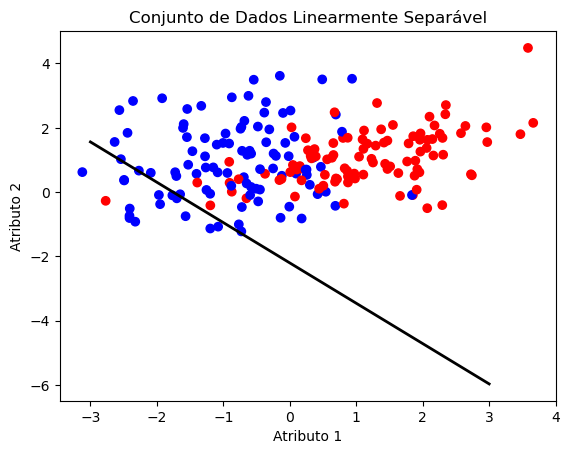

Acurácia do Perceptron: 0.425
Acurácia do MLPClassifier: 0.725


In [16]:
# Conjunto de dados linearmente separável
X, y = make_classification(
    n_samples=200,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    random_state=42,
)

# Divisão dos dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Normalização dos dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Treinamento e previsão do Perceptron
perceptron = Perceptron(eta=0.1, n_iter=1000)
perceptron.fit(X_train, y_train)
y_pred_perceptron = perceptron.predict(X_test)
accuracy_perceptron = accuracy_score(y_test, y_pred_perceptron)

# Treinamento e previsão do MLPClassifier
mlp = MLPClassifier(hidden_units=10, learning_rate=0.1, n_epochs=10000)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)

# Plot dos dados e da separação das classes pelo Perceptron
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="bwr")
plt.title("Conjunto de Dados Linearmente Separável")
plt.xlabel("Atributo 1")
plt.ylabel("Atributo 2")

# Plot da reta de separação pelo Perceptron
w = perceptron.w_
x_plot = np.linspace(-3, 3, 100)
y_plot = (-w[0] - w[1] * x_plot) / w[2]
plt.plot(x_plot, y_plot, color="black", linestyle="-", linewidth=2)

plt.show()

# Imprimir a acurácia dos classificadores
print("Acurácia do Perceptron:", accuracy_perceptron)
print("Acurácia do MLPClassifier:", accuracy_mlp)

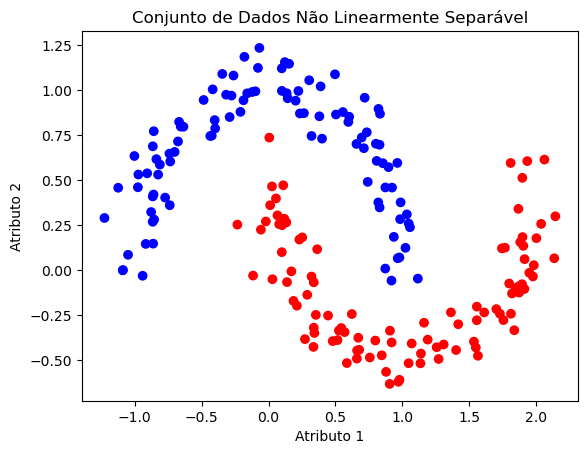

Acurácia do Perceptron: 0.45
Acurácia do MLPClassifier: 0.975


In [17]:
# Conjunto de dados não linearmente separável
X, y = make_moons(n_samples=200, noise=0.1, random_state=42)

# Divisão dos dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Normalização dos dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Treinamento e previsão do Perceptron
perceptron.fit(X_train, y_train)
y_pred_perceptron = perceptron.predict(X_test)
accuracy_perceptron = accuracy_score(y_test, y_pred_perceptron)

# Treinamento e previsão do MLPClassifier
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)

# Plot dos dados e da separação das classes pelo Perceptron
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="bwr")
plt.title("Conjunto de Dados Não Linearmente Separável")
plt.xlabel("Atributo 1")
plt.ylabel("Atributo 2")

plt.show()

# Imprimir a acurácia dos classificadores
print("Acurácia do Perceptron:", accuracy_perceptron)
print("Acurácia do MLPClassifier:", accuracy_mlp)

## Conclusão:



O classificador Perceptron é um algoritmo simples e amplamente utilizado para tarefas de classificação binária, suas vantagens são: simplicidade, eficiência e convergência garantida. Porém, suas destavagens envolvem a sensibilidade a outliers e limitações a quantidade de classes.

No caso específico dos dados de treinamento fornecidos, o Perceptron classificou corretamente duas das três amostras, atribuindo a classe -1 para a primeira e terceira amostra, e a classe 1 para a segunda amostra. Um 'next step' possível seria tentar melhorar o algoritmo do Perceptron adicionando os parâmetros existentes na biblioteca do scikit-learn Perceptron que utiliza regularização e alpha, como também adicionar um 'GridSearch' para os hiperparâmetros.

Já para o classificador Multilayer Perceptron (MLP),  é um modelo mais complexo e flexível em comparação com o Perceptron simples, tem como diferenças a capacidade de aprender funções mais complexas por conta das classes, adaptação de camadas e problemas. Porém, existe um maior entedimento de como funciona a rede neural para abstrair mais do que pode ser feito com ela, como custo computacional ser maior e ter maiores sensibilidades aos hiperparâmetros.

Em síntese, sobre o que pode ser analisado do projeto, a implementação do Perceptron não foi muito favorável devido aos valores observados, já o MLP deu um 'fit' melhor e conseguiu fazer a classificação com boas métricas, destaque para a classificação com os dados não linearmente separáveis, onde o MLP teve uma acurácia de 97.5%